In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import os
import umap
import matplotlib.pyplot as plt
import random as rnd
import itertools
import time

In [2]:
import distances
import linalg_tools as lt
import network_tools as nt

### Data

Import data

In [3]:
data = pd.read_csv('/Volumes/lucia_ext/bioprofiling/loan_data/morphofeatures_immunodeficiencies.csv')

In [4]:
features = data.iloc[:,:-3]
metadata = data.iloc[:,-3:]

In [5]:
metadata.head()

,Metadata_Deficiency,Metadata_Donor,Metadata_Well
0,ND,1,A07
1,ND,1,A07
2,ND,1,A07
3,ND,1,A07
4,ND,1,A07


Create UMAP network

In [6]:
rndstate = np.random.RandomState()
datamap_dl = umap.umap_.fuzzy_simplicial_set(features.values[:,1:], 15, rndstate, "euclidean")
graph_dl = nx.from_scipy_sparse_matrix(datamap_dl[0], create_using = nx.Graph)

Add metadata as node attributes

In [7]:
labels_list = metadata['Metadata_Deficiency'].values.tolist()
nodes = list(range(len(graph_dl)))
labels_dict = dict(zip(nodes, labels_list))
nx.set_node_attributes(graph_dl, labels_dict, 'deficiency')

In [8]:
nx.get_node_attributes(graph_dl, 'deficiency')[100]

'ARPC1B'

In [9]:
set(metadata['Metadata_Deficiency'])

{'ARPC1B', 'ND', 'WAS'}

### Have a look at network

In [10]:
nx.number_of_nodes(graph_dl)

759

In [11]:
nx.number_of_edges(graph_dl)

9548

In [12]:
nx.density(graph_dl)

0.033191847348093766

In [13]:
nx.average_clustering(graph_dl)

0.34453468557327555

In [14]:
nt.avg_deg(graph_dl)

25.159420289855074

Cumulative degree distribution

-2.226512259310414

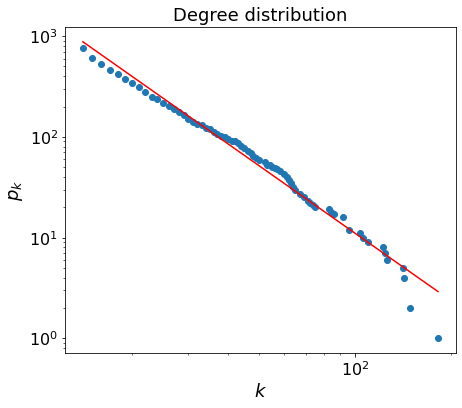

In [15]:
paras = nt.fitting(graph_dl, plot=True)
paras[0]

Regular degree distribution

-1.8801588650021497

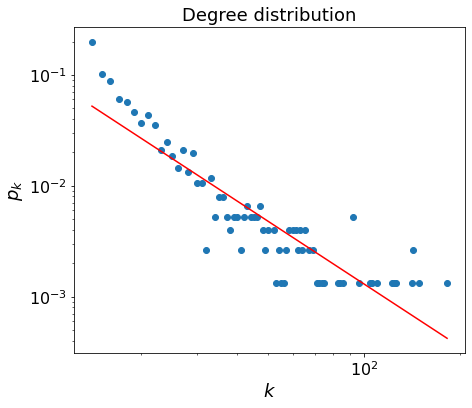

In [18]:
paras = nt.fitting(graph_dl, plot=True, cumulative=False)
paras[0]

In [16]:
max(list(d for n, d in graph_dl.degree()))

182

In [17]:
nx.number_connected_components(graph_dl)

1

### Visualize network

In [21]:
pos_spring = nx.spring_layout(graph_dl)
pos_spectr = nx.spectral_layout(graph_dl)
d = dict(graph_dl.degree)

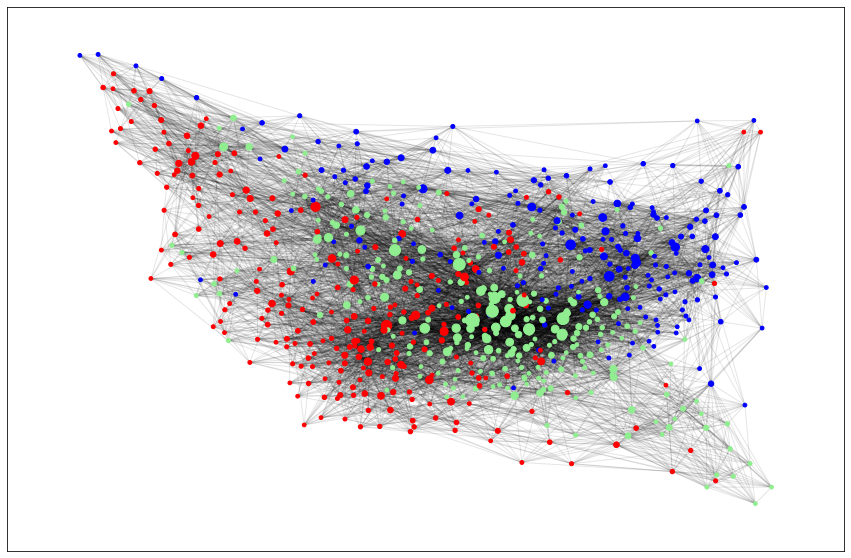

In [22]:
fig = plt.figure(figsize=(15, 10))
color_state_map = {'ARPC1B':'red', 'ND':'lightgreen', 'WAS':'blue'}
nx.draw_networkx_edges(graph_dl, pos=pos_spring, alpha=0.1)
nx.draw_networkx_nodes(graph_dl, pos=pos_spring, node_size=[v for v in d.values()], 
                       node_color=[color_state_map[node[1]['deficiency']] for node in graph_dl.nodes(data=True)])
plt.show()

In the plot above, the node size is directly proportional to the node degree.

- Red: patients without the ARPC1B protein
- Green: normal donors
- Blue: patients without the WASP protein

Loan said in email: "ND: normal donors = healthy, ARPC1B: patients without the ARPC1B protein, WAS: patients without the WASP protein. Rows for each deficiency should be more similar than rows from different deficiencies. **We can also safely assume that ARPC1B and WAS should be a bit closer to each other than to ND rows**.", which does not seem to be the case looking at the plot above, but maybe the one below a little bit?

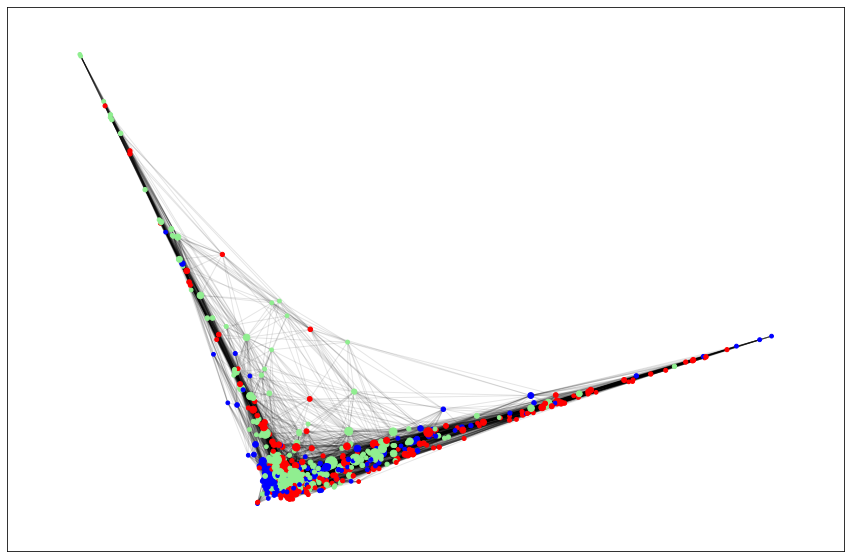

In [23]:
fig = plt.figure(figsize=(15, 10))
color_state_map = {'ARPC1B':'red', 'ND':'lightgreen', 'WAS':'blue'}
nx.draw_networkx_edges(graph_dl, pos=pos_spectr, alpha=0.1)
nx.draw_networkx_nodes(graph_dl, pos=pos_spectr, node_size=[v for v in d.values()], 
                       node_color=[color_state_map[node[1]['deficiency']] for node in graph_dl.nodes(data=True)])
plt.show()

### Checking that nodes in the same category are closer to each other than nodes in different categories

Now I will (kind of) check what the median distance between and within the three labels ARPC1B, ND and WAS are (using the two distances).

In [11]:
ARPC1B_data = [node for node in graph_dl.nodes(data=True) if node[1]['deficiency']=='ARPC1B']
ND_data = [node for node in graph_dl.nodes(data=True) if node[1]['deficiency']=='ND']
WAS_data = [node for node in graph_dl.nodes(data=True) if node[1]['deficiency']=='WAS']

In [14]:
iterations = 10

medians_an1 = []
medians_aa1 = []
medians_aw1 = []
medians_nn1 = []
medians_nw1 = []
medians_ww1 = []

medians_an2 = []
medians_aa2 = []
medians_aw2 = []
medians_nn2 = []
medians_nw2 = []
medians_ww2 = []

for i in range(iterations):
    ARPC1B_sample = rnd.sample(ARPC1B_data, 5)
    ND_sample = rnd.sample(ND_data, 5)
    WAS_sample = rnd.sample(WAS_data, 5)
    
    a_n = [[distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number),
            distances.expected_rw_distance(graph_dl, n1[0], n2[0])]
            for n1 in ARPC1B_sample for n2 in ND_sample]
    a_a = [[distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number),
            distances.expected_rw_distance(graph_dl, n1[0], n2[0])]
            for n1 in ARPC1B_sample for n2 in ARPC1B_sample]
    a_w = [[distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number),
            distances.expected_rw_distance(graph_dl, n1[0], n2[0])]
            for n1 in ARPC1B_sample for n2 in WAS_sample]
    n_w = [[distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number),
            distances.expected_rw_distance(graph_dl, n1[0], n2[0])]
            for n1 in ND_sample for n2 in WAS_sample]
    n_n = [[distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number),
            distances.expected_rw_distance(graph_dl, n1[0], n2[0])]
            for n1 in ND_sample for n2 in ND_sample]
    n_w = [[distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number),
            distances.expected_rw_distance(graph_dl, n1[0], n2[0])]
            for n1 in ND_sample for n2 in WAS_sample]
    w_w = [[distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number),
            distances.expected_rw_distance(graph_dl, n1[0], n2[0])]
            for n1 in WAS_sample for n2 in WAS_sample]
    
    medians_an1.append(np.median(np.array(a_n)[0]))
    medians_aa1.append(np.median(np.array(a_a)[0]))
    medians_aw1.append(np.median(np.array(a_w)[0]))
    medians_nn1.append(np.median(np.array(n_n)[0]))
    medians_nw1.append(np.median(np.array(n_w)[0]))
    medians_ww1.append(np.median(np.array(w_w)[0]))

    medians_an2.append(np.median(np.array(a_n)[1]))
    medians_aa2.append(np.median(np.array(a_a)[1]))
    medians_aw2.append(np.median(np.array(a_w)[1]))
    medians_nn2.append(np.median(np.array(n_n)[1]))
    medians_nw2.append(np.median(np.array(n_w)[1]))
    medians_ww2.append(np.median(np.array(w_w)[1]))

KeyboardInterrupt: 

In [23]:
print(f'median_an1: {np.median(medians_an1)}')
print(f'median_aa1: {np.median(medians_aa1)}')
print(f'median_aw1: {np.median(medians_aw1)}')
print(f'median_nn1: {np.median(medians_nn1)}')
print(f'median_nw1: {np.median(medians_nw1)}')
print(f'median_ww1: {np.median(medians_ww1)}')

print(f'median_an2: {np.median(medians_an2)}')
print(f'median_aa2: {np.median(medians_aa2)}')
print(f'median_aw2: {np.median(medians_aw2)}')
print(f'median_nn2: {np.median(medians_nn2)}')
print(f'median_nw2: {np.median(medians_nw2)}')
print(f'median_ww2: {np.median(medians_ww2)}')

median_an1: 1.6519521957456451
median_aa1: 0.6449542769333989
median_aw1: 1.7083076363244318
median_nn1: 0.6427186715108423
median_nw1: 1.686934542021073
median_ww1: 0.6459886376799839
median_an2: 1.646456716952628
median_aa2: 1.6324167226739346
median_aw2: 1.6559735622135696
median_nn2: 1.566739605826743
median_nw2: 1.5581932432403307
median_ww2: 1.6534251071616255


In [26]:
data1 = [[np.median(medians_aa1), np.median(medians_an1), np.median(medians_aw1)], 
         [np.median(medians_an1), np.median(medians_nn1), np.median(medians_nw1)],
         [np.median(medians_aw1), np.median(medians_nw1), np.median(medians_ww1)]]

data2 = [[np.median(medians_aa2), np.median(medians_an2), np.median(medians_aw2)], 
         [np.median(medians_an2), np.median(medians_nn2), np.median(medians_nw2)],
         [np.median(medians_aw2), np.median(medians_nw2), np.median(medians_ww2)]]

In [27]:
df1 = pd.DataFrame(data1, columns=['ARPC1B', 'ND', 'WAS'], index=['ARPC1B', 'ND', 'WAS'])
df2 = pd.DataFrame(data2, columns=['ARPC1B', 'ND', 'WAS'], index=['ARPC1B', 'ND', 'WAS'])

In [28]:
df1

,ARPC1B,ND,WAS
ARPC1B,0.644954,1.651952,1.708308
ND,1.651952,0.642719,1.686935
WAS,1.708308,1.686935,0.645989


In [29]:
df2

,ARPC1B,ND,WAS
ARPC1B,1.632417,1.646457,1.655974
ND,1.646457,1.566740,1.558193
WAS,1.655974,1.558193,1.653425


Hmmm it does not look good. I will try again with bigger samples and more iterations, but only with distance 2, since it's a little faster

In [16]:
import time

In [18]:
theta = 4
large_number = 100
iterations = 20

medians_an2_v2 = []
medians_aa2_v2 = []
medians_aw2_v2 = []
medians_nn2_v2 = []
medians_nw2_v2 = []
medians_ww2_v2 = []

for i in range(iterations):
    start = time.time()
    print(f'starting iteration: {i}')
    ARPC1B_sample = rnd.sample(ARPC1B_data, 10)
    ND_sample = rnd.sample(ND_data, 10)
    WAS_sample = rnd.sample(WAS_data, 10)
    
    a_n = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ARPC1B_sample for n2 in ND_sample]
    a_a = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ARPC1B_sample for n2 in ARPC1B_sample]
    a_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ARPC1B_sample for n2 in WAS_sample]
    n_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ND_sample for n2 in WAS_sample]
    n_n = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ND_sample for n2 in ND_sample]
    n_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ND_sample for n2 in WAS_sample]
    w_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in WAS_sample for n2 in WAS_sample]

    medians_an2_v2.append(np.median(np.array(a_n)))
    medians_aa2_v2.append(np.median(np.array(a_a)))
    medians_aw2_v2.append(np.median(np.array(a_w)))
    medians_nn2_v2.append(np.median(np.array(n_n)))
    medians_nw2_v2.append(np.median(np.array(n_w)))
    medians_ww2_v2.append(np.median(np.array(w_w)))
    
    end = time.time()
    print(f'elapsed time for iteration {i}: {end-start}')

starting iteration: 0
elapsed time for iteration 0: 144.39131593704224
starting iteration: 1
elapsed time for iteration 1: 150.65995597839355
starting iteration: 2
elapsed time for iteration 2: 164.87139296531677
starting iteration: 3
elapsed time for iteration 3: 189.57207894325256
starting iteration: 4
elapsed time for iteration 4: 178.80142092704773
starting iteration: 5
elapsed time for iteration 5: 151.30180883407593
starting iteration: 6
elapsed time for iteration 6: 137.12056517601013
starting iteration: 7
elapsed time for iteration 7: 155.45804381370544
starting iteration: 8
elapsed time for iteration 8: 205.72584700584412
starting iteration: 9
elapsed time for iteration 9: 213.8454191684723
starting iteration: 10
elapsed time for iteration 10: 199.40989589691162
starting iteration: 11
elapsed time for iteration 11: 200.08628392219543
starting iteration: 12
elapsed time for iteration 12: 215.5911979675293
starting iteration: 13
elapsed time for iteration 13: 216.14220786094666


In [22]:
data2 = [[np.median(medians_aa2_v2), np.median(medians_an2_v2), np.median(medians_aw2_v2)], 
         [np.median(medians_an2_v2), np.median(medians_nn2_v2), np.median(medians_nw2_v2)],
         [np.median(medians_aw2_v2), np.median(medians_nw2_v2), np.median(medians_ww2_v2)]]

In [23]:
df2 = pd.DataFrame(data2, columns=['ARPC1B', 'ND', 'WAS'], index=['ARPC1B', 'ND', 'WAS'])

In [24]:
df2

,ARPC1B,ND,WAS
ARPC1B,0.688917,0.720526,0.787500
ND,0.720526,0.612024,0.746812
WAS,0.787500,0.746812,0.618114


This looks much better! - The distances within the classes are smaller than the distances between the classes. Just "for fun", I will try with a different theta.

In [ ]:
theta = 0.5
large_number = 100
iterations = 20

medians_an2_v3 = []
medians_aa2_v3 = []
medians_aw2_v3 = []
medians_nn2_v3 = []
medians_nw2_v3 = []
medians_ww2_v3 = []

for i in range(iterations):
    start = time.time()
    print(f'starting iteration: {i}')
    ARPC1B_sample = rnd.sample(ARPC1B_data, 10)
    ND_sample = rnd.sample(ND_data, 10)
    WAS_sample = rnd.sample(WAS_data, 10)
    
    a_n = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ARPC1B_sample for n2 in ND_sample]
    a_a = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ARPC1B_sample for n2 in ARPC1B_sample]
    a_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ARPC1B_sample for n2 in WAS_sample]
    n_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ND_sample for n2 in WAS_sample]
    n_n = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ND_sample for n2 in ND_sample]
    n_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in ND_sample for n2 in WAS_sample]
    w_w = [distances.diss_distance(n1[0], n2[0], theta, graph_dl, large_number)
            for n1 in WAS_sample for n2 in WAS_sample]

    medians_an2_v3.append(np.median(np.array(a_n)))
    medians_aa2_v3.append(np.median(np.array(a_a)))
    medians_aw2_v3.append(np.median(np.array(a_w)))
    medians_nn2_v3.append(np.median(np.array(n_n)))
    medians_nw2_v3.append(np.median(np.array(n_w)))
    medians_ww2_v3.append(np.median(np.array(w_w)))
    
    end = time.time()
    print(f'elapsed time for iteration {i}: {end-start}')

starting iteration: 0
elapsed time for iteration 0: 161.9485218524933
starting iteration: 1
elapsed time for iteration 1: 150.33847498893738
starting iteration: 2
elapsed time for iteration 2: 152.59720182418823
starting iteration: 3


In [ ]:
data3 = [[np.median(medians_aa2_v3), np.median(medians_an2_v3), np.median(medians_aw2_v3)], 
         [np.median(medians_an2_v3), np.median(medians_nn2_v3), np.median(medians_nw2_v3)],
         [np.median(medians_aw2_v3), np.median(medians_nw2_v3), np.median(medians_ww2_v3)]]

In [ ]:
df3 = pd.DataFrame(data3, columns=['ARPC1B', 'ND', 'WAS'], index=['ARPC1B', 'ND', 'WAS'])

In [ ]:
df3